### Qiskit code for the BB84 algorithm

In [1]:
import random
from qiskit_aer import Aer
from qiskit.compiler import transpile

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

NUMBER_OF_CIRCUITS = 100
DOES_EVE_EXIST = False
CHECK_MARK = u'\u2713'

In [2]:
def create_registers(eve_exists):
    alice_q = QuantumRegister(1, 'alice_q')
    bob_q = QuantumRegister(1, 'bob_q')
    bob_c = ClassicalRegister(1, 'bob_c')

    if eve_exists:
        eve_c = ClassicalRegister(1, 'eve_c')
        circ = QuantumCircuit(alice_q, bob_q, bob_c, eve_c)
    else:
        circ = QuantumCircuit(alice_q, bob_q, bob_c)
    return circ

In [4]:
def setup_alice(circ):
    alice_q = circ.qubits[0]

    if random.getrandbits(1):
        circ.x(alice_q)

    if random.getrandbits(1):
        circ.h(alice_q)

    return circ


def setup_bob(circ):
    bob_q = circ.qubits[1]
    bob_c = circ.clbits[0]

    if random.getrandbits(1):
        circ.h(bob_q)

    circ.measure(bob_q, bob_c)
    return circ


def setup_eve(circ):
    bob_q = circ.qubits[1]
    eve_c = circ.clbits[1]

    circ.barrier()
    circ.measure(bob_q, eve_c)
    circ.barrier()
    return circ

In [5]:
def make_new_circuit(eve_exists):
    circ = create_registers(eve_exists)
    alice_q = circ.qubits[0]
    bob_q = circ.qubits[1]
    bob_c = circ.clbits[0]

    circ = setup_alice(circ)

    circ.swap(alice_q, bob_q)

    if eve_exists:
        circ = setup_eve(circ)

    circ = setup_bob(circ)

    return circ

In [6]:
def create_circuits(how_many, does_eve_exist):
    circuits = []
    for i in range(how_many):
        circuits.append(make_new_circuit(does_eve_exist)) 
    return circuits

In [18]:
def run_the_job(circuits):
    device = Aer.get_backend('qasm_simulator')
    shots=1
    qc_transpiled = transpile(circuits, backend=device)

    job = device.run(qc_transpiled, shots=shots, memory=True)
    return job.result()

In [8]:
def print_alice_bits(circuits):
    print('alice bits: ', end='')
    for circ in circuits:
        bit = 1 if 'x' in circ.count_ops() else 0
        print(bit, end='')
    print('')

In [9]:
def bob_bit_value(circ, memory):
    return memory[0][0]

In [10]:
def print_bob_bits(circuits, result):
    print('bob bits  : ', end='')
    for circ in circuits:
        memory = result.get_memory(circ)
        print(bob_bit_value(circ, memory), end='')
    print('')

In [11]:
def had_agreement(circ):
    gate_counts = circ.count_ops()
    return not ('h' in gate_counts and gate_counts['h'] == 1)

In [12]:
def print_had_agreements(circuits):
    number_of_agreements = 0
    print('hads agree? ', end='')
    for circ in circuits:
        if had_agreement(circ):
            print(CHECK_MARK, end='')
            number_of_agreements += 1
        else:
            print(' ', end='')
    print('')
    return number_of_agreements

In [13]:
def alice_bit_value(circ):
    return 1 if 'x' in circ.count_ops() else 0

In [14]:
def bit_value_agreement(circ, result):
    memory = result.get_memory(circ)
    return alice_bit_value(circ) == int(
        bob_bit_value(circ, memory))

In [15]:
def print_bit_agreements(circuits, result,
                         number_of_agreements):
    number_tested = 0
    is_eve_detected = False
    i = 0

    print('bits agree? ', end='')
    while number_tested < number_of_agreements // 2:
        if had_agreement(circuits[i]):
            if bit_value_agreement(circuits[i], result):
                print(CHECK_MARK, end='')
                number_tested += 1
            else:
                is_eve_detected = True
                print('X')
                break
        else:
            print(' ', end='')
        i += 1

    print()

    return i, is_eve_detected

In [16]:
def print_key(circuits, number_of_circuits, how_many_for_testing):
    print('key       :', end='')
    for i in range(how_many_for_testing + 1):
        print(' ', end='')
    for i in range(i, NUMBER_OF_CIRCUITS):
        if had_agreement(circuits[i]):
            print(alice_bit_value(circuits[i]), end='')
        else:
            print(' ', end='')

In [19]:
circuits = create_circuits(NUMBER_OF_CIRCUITS,
                           DOES_EVE_EXIST)             # 1

result = run_the_job(circuits)                         # 2

print_alice_bits(circuits)                             # 3

print_bob_bits(circuits, result)                       # 4

number_of_agreements = print_had_agreements(circuits)  # 5

how_many_for_testing, is_eve_detected = \
    print_bit_agreements(circuits, result,
                         number_of_agreements)         # 6

if is_eve_detected:                                    # 7
    print('INTRUDER ALERT!')
else:
    print_key(circuits, NUMBER_OF_CIRCUITS,
              how_many_for_testing) 

alice bits: 1101111101010010000111111000111111010110110000100111001101100010000010010101010010011110111000111011
bob bits  : 1101111101011100000010000100011111010110110000100101101101011010000111001111010010111111001101110010
hads agree? ✓✓✓✓  ✓ ✓✓ ✓   ✓✓ ✓ ✓     ✓✓ ✓✓✓✓ ✓✓✓ ✓✓ ✓✓✓✓ ✓✓✓✓ ✓ ✓✓✓      ✓✓           ✓ ✓✓    ✓✓ ✓   ✓ ✓ ✓   ✓ 
bits agree? ✓✓✓✓  ✓ ✓✓ ✓   ✓✓ ✓ ✓     ✓✓ ✓✓✓✓ ✓✓✓ ✓✓
key       :                                          1000 1001 1 011      10           1 10    11 1   1 0 1   1 

### Question 6

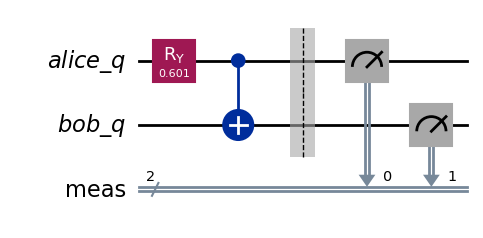

In [21]:
from qiskit import QuantumRegister, QuantumCircuit
from math import pi
import random
alice_q = QuantumRegister(1, 'alice_q')
bob_q = QuantumRegister(1, 'bob_q')
circ = QuantumCircuit(alice_q, bob_q)
circ.ry(pi/(random.uniform(2, 20)), alice_q[0])
circ.cx(0, 1)
circ.measure_all()
display(circ.draw('mpl'))

### Question 7

In [22]:
def setup_eve(circ):
    bob_q = circ.qubits[1]
    eve_c = circ.clbits[1]
    
    has_had = random.getrandbits(1)
    circ.barrier()
    if has_had:
        circ.h(bob_q)
    circ.measure(bob_q, eve_c)
    if has_had:
        circ.h(bob_q)
    circ.barrier()
    return circ

def had_agreement(circ):
    gate_counts = circ.count_ops()
    return not ('h' in gate_counts and gate_counts['h'] % 2 == 1)